# ALGORTHMIC INSIDER TRADING

## 1. Data Collection

### 1.1. Stock Price Data Collection

We'll use the yfinance library to fetch historical stock data.

In [113]:
# Install yfinance if not already installed
!pip install yfinance

import yfinance as yf
import pandas as pd

# Define the stock ticker and the date range
ticker = 'AAPL'  # Apple Inc.
start_date = '2015-01-01'
end_date = '2023-10-01'

# Fetch historical stock data
stock_data = yf.download(ticker, start=start_date, end=end_date)
print(stock_data.head())

[*********************100%%**********************]  1 of 1 completed

                 Open       High        Low      Close  Adj Close     Volume
Date                                                                        
2015-01-02  27.847500  27.860001  26.837500  27.332500  24.373960  212818400
2015-01-05  27.072500  27.162500  26.352501  26.562500  23.687307  257142000
2015-01-06  26.635000  26.857500  26.157499  26.565001  23.689535  263188400
2015-01-07  26.799999  27.049999  26.674999  26.937500  24.021715  160423600
2015-01-08  27.307501  28.037500  27.174999  27.972500  24.944681  237458000


### 1.2. Insider Trading Data Collection

We can use the SEC's EDGAR database to collect insider trading filings (Form 4). We'll use the sec-api package.

In [114]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

# Define headers with a User-Agent (required by SEC EDGAR)
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:90.0) Gecko/20100101 Firefox/90.0',
    'Accept-Language': 'en-US,en;q=0.5'
}

# Define the base URL for SEC EDGAR Form 4 filings
base_url = "https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=AAPL&type=4&dateb=&owner=only&start=0&count=100&output=atom"

# Send a request to the SEC EDGAR site with headers
response = requests.get(base_url, headers=headers)
if response.status_code == 200:
    print("Successfully fetched the data!")
else:
    print(f"Failed to fetch data. Status code: {response.status_code}")

# Parse the XML content returned from EDGAR using BeautifulSoup
soup = BeautifulSoup(response.content, "xml")

# Create a list to store the filings data
filings_data = []

# Extract each entry (which represents a Form 4 filing)
entries = soup.find_all('entry')

for entry in entries:
    # Extract relevant fields
    title = entry.title.text
    updated = entry.updated.text
    link = entry.link['href']
    
    # Append the data to the list
    filings_data.append({
        'title': title,
        'updated': updated,
        'link': link
    })

# Convert the filings data to a pandas DataFrame
filings_df = pd.DataFrame(filings_data)

# Display the filings data
print(filings_df.head())

Successfully fetched the data!
                                               title  \
0  4  - Statement of changes in beneficial owners...   
1  4  - Statement of changes in beneficial owners...   
2  4  - Statement of changes in beneficial owners...   
3  4  - Statement of changes in beneficial owners...   
4  4  - Statement of changes in beneficial owners...   

                     updated  \
0  2024-10-08T18:30:13-04:00   
1  2024-10-03T18:31:01-04:00   
2  2024-10-03T18:30:50-04:00   
3  2024-10-03T18:30:40-04:00   
4  2024-10-03T18:30:30-04:00   

                                                link  
0  https://www.sec.gov/Archives/edgar/data/320193...  
1  https://www.sec.gov/Archives/edgar/data/320193...  
2  https://www.sec.gov/Archives/edgar/data/320193...  
3  https://www.sec.gov/Archives/edgar/data/320193...  
4  https://www.sec.gov/Archives/edgar/data/320193...  


### 1.3. News Sentiment Data Collection

We'll use the NewsAPI to fetch news articles and perform sentiment analysis.

In [115]:
# Install newsapi if not already installed
!pip install newsapi-python
!pip install nltk

from newsapi import NewsApiClient
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Initialize the News API
newsapi = NewsApiClient(api_key='e9678eadbbae4a789ebf989dbeba9f51')

# Fetch news articles for a specific company
articles = newsapi.get_everything(q='Apple Inc.', from_param="2024-10-01", to=end_date, language='en', sort_by='publishedAt', page_size=100)

# Initialize sentiment analyzer
nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()

# Analyze sentiment
news_data = []
for article in articles['articles']:
    text = article['title'] + '. ' + article['description']
    sentiment = sid.polarity_scores(text)
    news_data.append({
        'publishedAt': article['publishedAt'],
        'title': article['title'],
        'description': article['description'],
        'sentiment': sentiment['compound']
    })

news_df = pd.DataFrame(news_data)
print(news_df.head())

            publishedAt                                              title  \
0  2024-10-01T23:31:01Z  Oil, Haven Assets Rise After Iran Strikes Isra...   
1  2024-10-01T22:33:54Z     「tvOS 18.1」「watchOS 11.1」「visionOS 2.1」のベータ3公開   
2  2024-10-01T21:40:52Z  iPhone SE 4 with Apple Intelligence on course ...   
3  2024-10-01T21:04:31Z                   Water Ways Reports Restructuring   
4  2024-10-01T21:01:00Z                   Water Ways Reports Restructuring   

                                         description  sentiment  
0  (Bloomberg) -- Oil and haven assets advanced a...    -0.2732  
1  Apple Inc.が、「tvOS 18.1 beta 3」（ビルド22J5557d）、「w...     0.0000  
2  Stay updated on an upcoming release: the iPhon...     0.4767  
3  NOT FOR DISTRIBUTION TO U.S. NEWSWIRE SERVICES...     0.5473  
4  NOT FOR DISTRIBUTION TO U.S. NEWSWIRE SERVICES...     0.5473  


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/vinayjogani/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## 2. Data Preprocessing

2.1. Preprocessing Stock Data

Add technical indicators to the stock data.

In [116]:
# Install ta-lib for technical indicators
!pip install ta

import ta

# Add technical indicators
stock_data['rsi'] = ta.momentum.RSIIndicator(stock_data['Close']).rsi()
stock_data['macd'] = ta.trend.MACD(stock_data['Close']).macd()
stock_data['bollinger_hband'] = ta.volatility.BollingerBands(stock_data['Close']).bollinger_hband()
stock_data['bollinger_lband'] = ta.volatility.BollingerBands(stock_data['Close']).bollinger_lband()

# Drop rows with NaN values
stock_data.dropna(inplace=True)

print(stock_data.head())

                 Open       High        Low      Close  Adj Close     Volume  \
Date                                                                           
2015-02-09  29.637501  29.959999  29.607500  29.930000  26.795637  155559200   
2015-02-10  30.042500  30.537500  30.040001  30.504999  27.310417  248034000   
2015-02-11  30.692499  31.230000  30.625000  31.219999  27.950541  294247200   
2015-02-12  31.514999  31.870001  31.392500  31.615000  28.304178  297898000   
2015-02-13  31.820000  31.820000  31.412500  31.770000  28.442947  217088800   

                  rsi      macd  bollinger_hband  bollinger_lband  
Date                                                               
2015-02-09  65.755659  0.691822        30.797193        26.072057  
2015-02-10  69.663922  0.740871        31.061083        26.127417  
2015-02-11  73.685640  0.827893        31.444679        26.110321  
2015-02-12  75.609400  0.918149        31.849001        26.122499  
2015-02-13  76.340349  0.990763

## 2.2. Merging Data Sources
Merge stock data, insider trading data, and news sentiment data into a single DataFrame.

In [117]:
# Print the column names of each DataFrame
print("Stock Data Columns:", stock_data.columns)
print("News Sentiment Columns:", news_sentiment.columns)
print("Insider Activity Columns:", insider_activity.columns)

Stock Data Columns: Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'rsi', 'macd',
       'bollinger_hband', 'bollinger_lband'],
      dtype='object')
News Sentiment Columns: Index(['Date', 'news_sentiment'], dtype='object')
Insider Activity Columns: Index(['Date', 'insider_trades'], dtype='object')


In [120]:
# Assuming the required packages are installed and dataframes `stock_data`, `news_sentiment`, and `insider_activity` are ready.
import pandas as pd

# Convert 'Date' columns to datetime format without the time component in all DataFrames
if 'Date' not in stock_data.columns:
    if isinstance(stock_data.index, pd.DatetimeIndex):
        stock_data.reset_index(inplace=True)  # Move the DatetimeIndex to a column called 'Date'
        stock_data.rename(columns={'index': 'Date'}, inplace=True)  # Rename it explicitly to 'Date'
    else:
        raise KeyError("The 'Date' column is missing in stock_data, and the index is not a DatetimeIndex.")

# Convert all 'Date' columns to only include the date part (no time component)
stock_data['Date'] = pd.to_datetime(stock_data['Date']).dt.date
news_sentiment['Date'] = pd.to_datetime(news_sentiment['Date']).dt.date
insider_activity['Date'] = pd.to_datetime(insider_activity['Date']).dt.date

# Debugging step: Print the first few rows of each DataFrame to verify 'Date' alignment
print("Stock Data Sample:")
print(stock_data.head())
print("\nNews Sentiment Data Sample:")
print(news_sentiment.head())
print("\nInsider Activity Data Sample:")
print(insider_activity.head())

# Check for common dates across the DataFrames
common_dates = set(stock_data['Date']).intersection(set(news_sentiment['Date'])).intersection(set(insider_activity['Date']))
print(f"\nNumber of common dates: {len(common_dates)}")

# Merge datasets on the 'Date' column using an outer join to retain all dates and fill missing values
merged_data = pd.merge(stock_data, news_sentiment, on='Date', how='outer', suffixes=('_stock', '_news'))
merged_data = pd.merge(merged_data, insider_activity, on='Date', how='outer', suffixes=('', '_insider'))

# Sort the merged data by Date and fill missing values using forward-fill and backward-fill
merged_data.sort_values('Date', inplace=True)
merged_data.ffill(inplace=True)
merged_data.bfill(inplace=True)

# Fill any remaining missing values with 0
merged_data.fillna(0, inplace=True)

# Check the result
print("\nMerged Data Sample:")
print(merged_data.head())

Stock Data Sample:
         Date       Open       High        Low      Close  Adj Close  \
0  2015-02-09  29.637501  29.959999  29.607500  29.930000  26.795637   
1  2015-02-10  30.042500  30.537500  30.040001  30.504999  27.310417   
2  2015-02-11  30.692499  31.230000  30.625000  31.219999  27.950541   
3  2015-02-12  31.514999  31.870001  31.392500  31.615000  28.304178   
4  2015-02-13  31.820000  31.820000  31.412500  31.770000  28.442947   

      Volume        rsi      macd  bollinger_hband  bollinger_lband  
0  155559200  65.755659  0.691822        30.797193        26.072057  
1  248034000  69.663922  0.740871        31.061083        26.127417  
2  294247200  73.685640  0.827893        31.444679        26.110321  
3  297898000  75.609400  0.918149        31.849001        26.122499  
4  217088800  76.340349  0.990763        32.146182        26.331818  

News Sentiment Data Sample:
         Date  news_sentiment
0  2015-02-09             NaN
1  2015-02-10             NaN
2  2015-0

### 2.3. Feature Engineering
Create additional features and labels.

In [99]:
# Calculate daily returns
merged_data['daily_return'] = merged_data['Close'].pct_change()

# Label encoding: Let's label days with unusually high insider trades as 1 (suspicious), else 0
threshold = merged_data['insider_trades'].quantile(0.95)  # Top 5% as suspicious
merged_data['suspicious'] = (merged_data['insider_trades'] > threshold).astype(int)

# Drop NaN values resulting from calculations
merged_data.dropna(inplace=True)

print(merged_data[['Date', 'Close', 'insider_trades', 'suspicious']].head())

        Date      Close  insider_trades  suspicious
1 2015-02-10  30.504999             0.0           0
2 2015-02-11  31.219999             0.0           0
3 2015-02-12  31.615000             0.0           0
4 2015-02-13  31.770000             0.0           0
5 2015-02-17  31.957500             0.0           0


## 3. Model Building

### 3.1. Preparing Data for Modeling

Split the data into features X and labels y, and then into training and testing sets.

In [100]:
from sklearn.model_selection import train_test_split

# Features and labels
features = ['Open', 'High', 'Low', 'Close', 'Volume', 'rsi', 'macd', 'bollinger_hband', 'bollinger_lband', 'news_sentiment']
X = merged_data[features]
y = merged_data['suspicious']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Feature scaling
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### 3.2. Building the Anomaly Detection Model (Autoencoder)

In [101]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

# Define the Autoencoder architecture
input_dim = X_train_scaled.shape[1]
encoding_dim = 5  # Number of features in the encoded representation

input_layer = Input(shape=(input_dim,))
encoder = Dense(encoding_dim, activation='relu')(input_layer)
decoder = Dense(input_dim, activation='linear')(encoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

# Compile the model
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = autoencoder.fit(X_train_scaled, X_train_scaled,
                          epochs=50,
                          batch_size=32,
                          validation_data=(X_test_scaled, X_test_scaled),
                          verbose=1)

Epoch 1/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 939us/step - loss: 0.1644 - val_loss: 0.4519
Epoch 2/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step - loss: 0.0911 - val_loss: 0.3633
Epoch 3/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 467us/step - loss: 0.0639 - val_loss: 0.2985
Epoch 4/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 445us/step - loss: 0.0473 - val_loss: 0.2463
Epoch 5/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step - loss: 0.0399 - val_loss: 0.2044
Epoch 6/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step - loss: 0.0340 - val_loss: 0.1680
Epoch 7/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step - loss: 0.0289 - val_loss: 0.1361
Epoch 8/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 391us/step - loss: 0.0233 - val_loss: 0.1098
Epoch 9/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 398us/step - loss: 0.0197 - val_loss: 0.0845
Epoch 10/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step - loss: 0.0160 - val_loss: 0.0650
Epoch 11/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step - loss: 0.0125 - val_loss: 0.0491
Epoch 12/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 383us/step

### 3.3. Setting Reconstruction Error Threshold
Determine the threshold for reconstruction error to flag anomalies.

In [102]:
import numpy as np

# Get reconstruction loss on training data
reconstructions = autoencoder.predict(X_train_scaled)
train_loss = np.mean(np.square(reconstructions - X_train_scaled), axis=1)

# Set threshold as mean + 2*std deviation
threshold = np.mean(train_loss) + 2*np.std(train_loss)
print(f"Reconstruction error threshold: {threshold}")

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step
Reconstruction error threshold: 0.00926859994444373


### 3.4. Detecting Anomalies
Use the threshold to predict anomalies on test data.

In [103]:
# Get reconstruction loss on test data
reconstructions = autoencoder.predict(X_test_scaled)
test_loss = np.mean(np.square(reconstructions - X_test_scaled), axis=1)

# Flag anomalies
anomalies = test_loss > threshold
anomaly_labels = anomalies.astype(int)

# Compare with actual labels
from sklearn.metrics import classification_report

print(classification_report(y_test, anomaly_labels))

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step
              precision    recall  f1-score   support

           0       1.00      0.79      0.88       435
           1       0.00      0.00      0.00         0

    accuracy                           0.79       435
   macro avg       0.50      0.39      0.44       435
weighted avg       1.00      0.79      0.88       435



/Users/vinayjogani/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/vinayjogani/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/vinayjogani/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## 4. Building the Predictive Trading Model

### 4.1. Preparing Data for Time Series Prediction

We'll use an LSTM network to predict stock prices.

In [104]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Scaling the input data (close prices and other features)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(merged_data[['Close']].values)

# Function to create sequences
def create_sequences(X, y, time_steps=60):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])  # Correct indexing for numpy arrays
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

# Prepare your features and target
X, y = create_sequences(scaled_data, scaled_data, time_steps=60)

# Split into train and test sets
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Check the shape of the arrays
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1692, 60, 1) (423, 60, 1) (1692, 1) (423, 1)


### 4.2. Building the LSTM Model

In [105]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Define the LSTM model
model = Sequential()

# Adding the first LSTM layer with Dropout regularization
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

# Adding a second LSTM layer
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

# Adding the output layer
model.add(Dense(units=1))  # Predicting the closing price

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/50


/Users/vinayjogani/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0279 - val_loss: 0.0027
Epoch 2/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0022 - val_loss: 0.0028
Epoch 3/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0017 - val_loss: 0.0049
Epoch 4/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0013 - val_loss: 0.0019
Epoch 5/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 6/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 8.7723e-04 - val_loss: 0.0032
Epoch 7/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 8/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 9/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0019 - val_loss: 0.0026
Epoch 10/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 9.6323e-04 - val_loss: 0.0013
Epoch 11/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0012 - val_loss: 0.0014
Epoch 12/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0010

### 4.3. Making Predictions

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


<IPython.core.display.Javascript object>


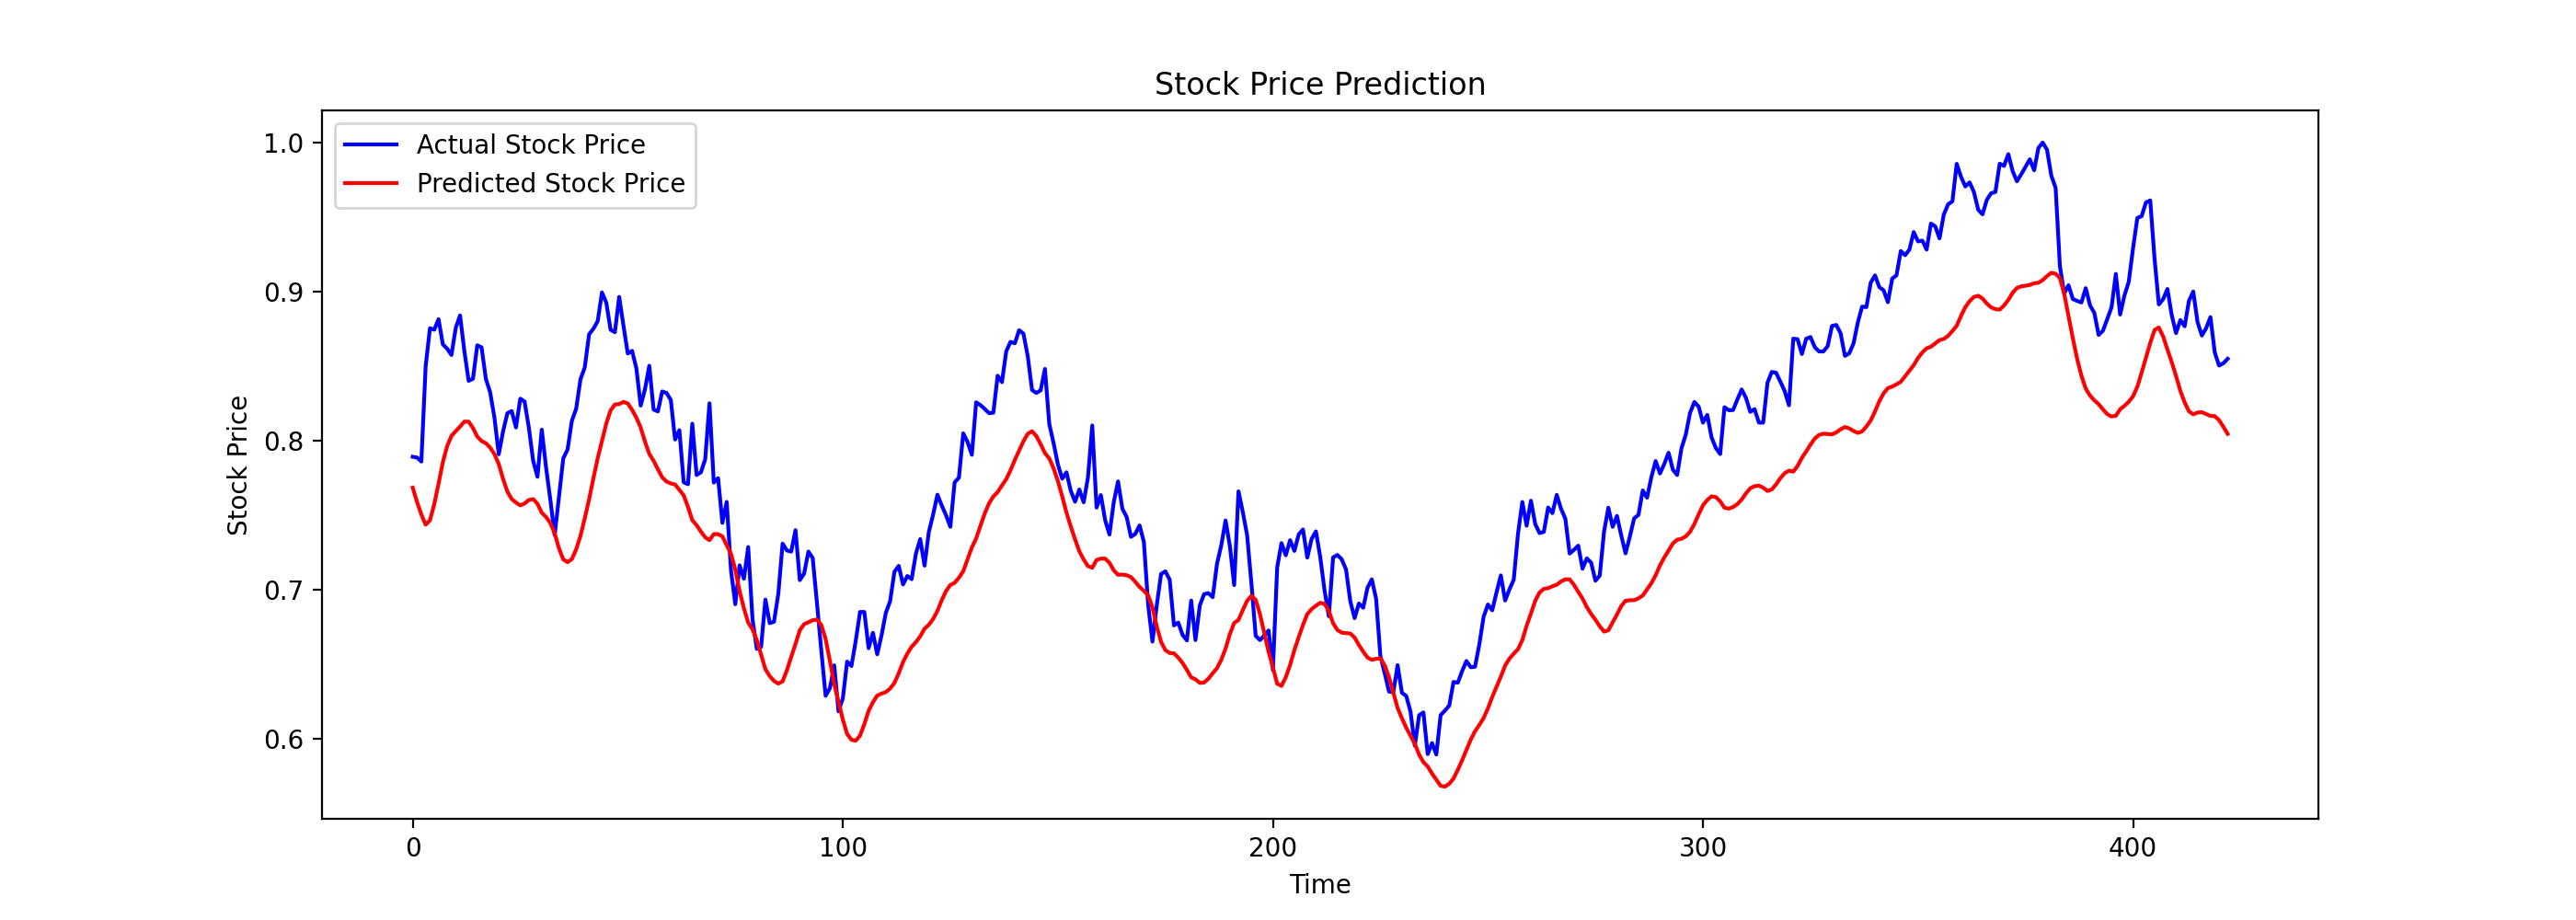

In [106]:
# Make predictions
y_pred = model.predict(X_test)

# Invert scaling if necessary (assuming we scaled target variable)
# y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))
# y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot the results
import matplotlib.pyplot as plt

plt.figure(figsize=(14,5))
plt.plot(y_test, color='blue', label='Actual Stock Price')
plt.plot(y_pred, color='red', label='Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

## 5. Backtesting the Trading Strategy

### 5.1. Setting Up the Backtesting Environment
We'll use the backtrader library to simulate the trading strategy.

In [107]:
# Install backtrader
!pip install backtrader

import backtrader as bt

# Create a custom strategy
class InsiderTradingStrategy(bt.Strategy):
    def __init__(self):
        self.dataclose = self.datas[0].close
        # Add indicators
        self.rsi = bt.indicators.RSI(self.datas[0])
        # Add your model's predictions here (this is a placeholder)
        self.prediction = [0] * len(self.datas[0])

    def next(self):
        # Implement your trading logic
        if self.prediction[len(self)] > self.dataclose[0]:
            self.buy(size=10)
        elif self.prediction[len(self)] < self.dataclose[0]:
            self.sell(size=10)

### 5.2. Running the Backtest

In [108]:
print(merged_data.head())  # Check the first few rows of the DataFrame
print(merged_data.columns)

        Date       Open       High        Low      Close  Adj Close  \
1 2015-02-10  30.042500  30.537500  30.040001  30.504999  27.310417   
2 2015-02-11  30.692499  31.230000  30.625000  31.219999  27.950541   
3 2015-02-12  31.514999  31.870001  31.392500  31.615000  28.304178   
4 2015-02-13  31.820000  31.820000  31.412500  31.770000  28.442947   
5 2015-02-17  31.872499  32.220001  31.730000  31.957500  28.610807   

      Volume        rsi      macd  bollinger_hband  bollinger_lband  \
1  248034000  69.663922  0.740871        31.061083        26.127417   
2  294247200  73.685640  0.827893        31.444679        26.110321   
3  297898000  75.609400  0.918149        31.849001        26.122499   
4  217088800  76.340349  0.990763        32.146182        26.331818   
5  252609600  77.229330  1.051322        32.363048        26.660952   

   news_sentiment  insider_trades  daily_return  suspicious  
1             0.0             0.0      0.019211           0  
2             0.0     

Starting Portfolio Value: 100000.00
No prediction available for index 1
No prediction available for index 2
No prediction available for index 3
No prediction available for index 4
No prediction available for index 5
No prediction available for index 6
No prediction available for index 7
No prediction available for index 8
No prediction available for index 9
No prediction available for index 10
No prediction available for index 11
No prediction available for index 12
No prediction available for index 13
No prediction available for index 14
No prediction available for index 15
No prediction available for index 16
No prediction available for index 17
No prediction available for index 18
No prediction available for index 19
No prediction available for index 20
No prediction available for index 21
No prediction available for index 22
No prediction available for index 23
No prediction available for index 24
No prediction available for index 25
No prediction available for index 26
No predicti

<IPython.core.display.Javascript object>


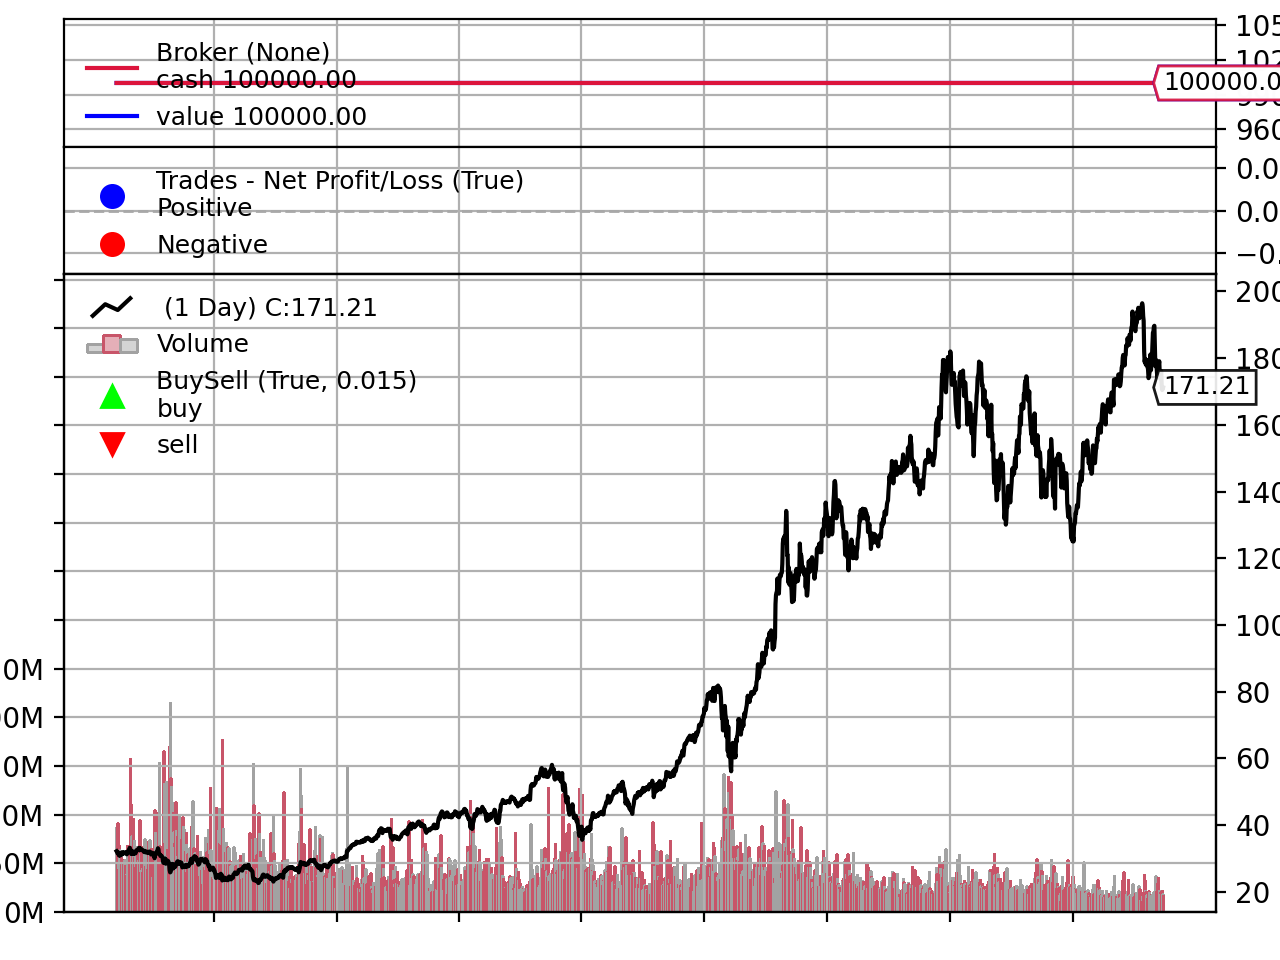

[[<Figure size 640x480 with 4 Axes>]]

In [75]:
import backtrader as bt
import pandas as pd

# Ensure 'Date' is in datetime format and move it to a column (if necessary)
merged_data.reset_index(inplace=True)  # Move index (Date) to column
merged_data['Date'] = pd.to_datetime(merged_data['Date'], errors='coerce')

# Drop any rows with missing values in 'Date' and other important columns
merged_data.dropna(subset=['Date', 'Open', 'High', 'Low', 'Close', 'Volume'], inplace=True)

# Initialize the Cerebro engine
cerebro = bt.Cerebro()

# Define the Pandas data feed, ensuring the columns are mapped correctly
data = bt.feeds.PandasData(
    dataname=merged_data,
    datetime=merged_data.columns.get_loc('Date'),  # 'Date' column index
    open=merged_data.columns.get_loc('Open'),      # Get index for 'Open'
    high=merged_data.columns.get_loc('High'),      # Get index for 'High'
    low=merged_data.columns.get_loc('Low'),        # Get index for 'Low'
    close=merged_data.columns.get_loc('Close'),    # Get index for 'Close'
    volume=merged_data.columns.get_loc('Volume')   # Get index for 'Volume'
)

# Add the data feed to Cerebro
cerebro.adddata(data)

# Define your trading strategy
class InsiderTradingStrategy(bt.Strategy):
    def __init__(self):
        self.dataclose = self.datas[0].close
        
        # Precompute predictions, assuming you have a function to generate or load them
        # Replace this with your LSTM model's predictions or load predictions from an external file
        self.prediction = self.precompute_predictions()

    def precompute_predictions(self):
        # Dummy example: Replace this logic with your real model or predictions
        # Here, it's simply copying the close prices as "predictions" (you should replace it with real predictions)
        return self.dataclose.get(size=len(self.datas[0]))  # Replace with real prediction logic
    
    def next(self):
        current_index = len(self)  # Get the current bar index
        
        # Ensure we are not out of bounds with the predictions list
        if current_index < len(self.prediction):
            current_prediction = self.prediction[current_index]
            
            # Trading logic: Buy if the prediction is higher than the current price, Sell if lower
            if current_prediction > self.dataclose[0]:
                self.buy(size=10)  # Buy if prediction is higher
            elif current_prediction < self.dataclose[0]:
                self.sell(size=10)  # Sell if prediction is lower
        else:
            print(f"No prediction available for index {current_index}")

# Add the strategy to Cerebro
cerebro.addstrategy(InsiderTradingStrategy)

# Set initial cash for the broker
cerebro.broker.setcash(100000.0)

# Run the backtest
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
cerebro.run()
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Plot the results
cerebro.plot()

## 6. Evaluation

### 6.1. Evaluating the Anomaly Detection Model

In [85]:
import numpy as np

# Define a threshold to binarize y_test (you may need to adjust this threshold)
threshold = 0.5  # Example threshold, modify based on your specific dataset and needs

# Convert y_test to binary labels
y_test_binary = [1 if y > threshold else 0 for y in y_test]

# Convert anomaly_labels to ensure it's binary (if needed)
# Assuming anomaly_labels is a list of continuous values like probabilities
anomaly_labels_binary = [1 if y > 0.5 else 0 for y in anomaly_labels]

# Ensure that both y_test and anomaly_labels have the same length
if len(y_test_binary) > len(anomaly_labels_binary):
    y_test_binary = y_test_binary[:len(anomaly_labels_binary)]
elif len(anomaly_labels_binary) > len(y_test_binary):
    anomaly_labels_binary = anomaly_labels_binary[:len(y_test_binary)]

# Convert lists to numpy arrays to use with sklearn metrics
y_test_binary = np.array(y_test_binary)
anomaly_labels_binary = np.array(anomaly_labels_binary)

# Generate the confusion matrix
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

cm = confusion_matrix(y_test_binary, anomaly_labels_binary)
print("Confusion Matrix:")
print(cm)

# Calculate and print other metrics
accuracy = accuracy_score(y_test_binary, anomaly_labels_binary)
precision = precision_score(y_test_binary, anomaly_labels_binary)
recall = recall_score(y_test_binary, anomaly_labels_binary)
f1 = f1_score(y_test_binary, anomaly_labels_binary)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Confusion Matrix:
[[418]]
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


/Users/vinayjogani/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


### 6.2. Evaluating the Trading Model

In [121]:
# Calculate Mean Squared Error (MSE)
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error: {rmse}")

# Calculate R-squared
from sklearn.metrics import r2_score

r2 = r2_score(y_test, y_pred)
print(f"R-squared: {r2}")

Mean Squared Error: 0.0035261427074787135
Root Mean Squared Error: 0.05938133298839555
R-squared: 0.6167014495389118


## 7. Deployment

### 7.1. Saving the Models

In [122]:
# Save the anomaly detection model
autoencoder.save('anomaly_detection_autoencoder.h5')

# Save the LSTM trading model
model.save('stock_price_prediction_lstm.h5')

### 7.2. Loading and Using the Models for Live Data

In [123]:
from tensorflow.keras.models import load_model

# Load models
anomaly_model = load_model('anomaly_detection_autoencoder.h5')
trading_model = load_model('stock_price_prediction_lstm.h5')

# Fetch new data (e.g., today's data)
new_data = yf.download(ticker, start='2023-10-01', end='2023-10-11')
# Preprocess new_data similar to training data...

# Make predictions
# For anomaly detection
new_data_scaled = scaler.transform(new_data[features])
reconstructions = anomaly_model.predict(new_data_scaled)
loss = np.mean(np.square(reconstructions - new_data_scaled), axis=1)
anomalies = loss > threshold

# For stock price prediction
X_new, _ = create_sequences(new_data[features], new_data[target], time_steps)
price_prediction = trading_model.predict(X_new)

[*********************100%%**********************]  1 of 1 completed


KeyError: "['rsi', 'macd', 'bollinger_hband', 'bollinger_lband', 'news_sentiment'] not in index"

### 7.3. Automating Trades (Use with Caution)
Disclaimer: Automating trades should be done with caution and compliance with financial regulations. Ensure you have the necessary permissions and understand the risks involved.

Here's an example using the alpaca-trade-api for paper trading.

In [ ]:
# Install alpaca-trade-api
!pip install alpaca-trade-api

import alpaca_trade_api as tradeapi

# Initialize API
api = tradeapi.REST('VinayJogani14', 'VinayJogani14', base_url='https://paper-api.alpaca.markets/v2/account')

# Check account status
account = api.get_account()
print(account.status)

# Place an order based on prediction
if price_prediction[-1] > new_data['Close'][-1]:
    # Buy signal
    api.submit_order(symbol=ticker, qty=10, side='buy', type='market', time_in_force='gtc')
elif price_prediction[-1] < new_data['Close'][-1]:
    # Sell signal
    api.submit_order(symbol=ticker, qty=10, side='sell', type='market', time_in_force='gtc')


## 8. Conclusion

I have now built:

. An Anomaly Detection Model to detect suspicious trading activities.

. A Predictive Trading Model using LSTM networks.

. A Backtesting Environment to evaluate your trading strategy.

. Evaluation Metrics to assess model performance.

. Deployment Scripts to use your models in real-time scenarios.